# Terminal NGP

In [1]:
import torch
import argparse

from nerf.provider import NeRFDataset
from nerf.gui import NeRFGUI
from nerf.utils import *

from functools import partial
from loss import huber_loss

import sys

In [2]:
sys.argv = ['main_nerf.py', '../town3_video/', '--workspace', '3_command']

if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('path', type=str)
    parser.add_argument('--test', action='store_true', help="test mode")
    parser.add_argument('--workspace', type=str, default='workspace')
    parser.add_argument('--seed', type=int, default=0)

    ### training options
    parser.add_argument('--iters', type=int, default=40000, help="training iters")
    parser.add_argument('--lr', type=float, default=2e-3, help="initial learning rate")
    parser.add_argument('--ckpt', type=str, default='latest')
    parser.add_argument('--num_rays', type=int, default=4096, help="num rays sampled per image for each training step")
    parser.add_argument('--cuda_ray', action='store_true', help="use CUDA raymarching instead of pytorch")
    parser.add_argument('--max_steps', type=int, default=1024, help="max num steps sampled per ray (only valid when using --cuda_ray)")
    parser.add_argument('--num_steps', type=int, default=512, help="num steps sampled per ray (only valid when NOT using --cuda_ray)")
    parser.add_argument('--upsample_steps', type=int, default=0, help="num steps up-sampled per ray (only valid when NOT using --cuda_ray)")
    parser.add_argument('--update_extra_interval', type=int, default=16, help="iter interval to update extra status (only valid when using --cuda_ray)")
    parser.add_argument('--max_ray_batch', type=int, default=4096, help="batch size of rays at inference to avoid OOM (only valid when NOT using --cuda_ray)")

    ### network backbone options
    parser.add_argument('--fp16', action='store_true', help="use amp mixed precision training")

    ### dataset options
    parser.add_argument('--color_space', type=str, default='srgb', help="Color space, supports (linear, srgb)")
    parser.add_argument('--preload', action='store_true', help="preload all data into GPU, accelerate training but use more GPU memory")
    # (the default value is for the fox dataset)
    parser.add_argument('--bound', type=float, default=2, help="assume the scene is bounded in box[-bound, bound]^3, if > 1, will invoke adaptive ray marching.")
    parser.add_argument('--scale', type=float, default=0.33, help="scale camera location into box[-bound, bound]^3")
    parser.add_argument('--dt_gamma', type=float, default=1/128, help="dt_gamma (>=0) for adaptive ray marching. set to 0 to disable, >0 to accelerate rendering (but usually with worse quality)")
    parser.add_argument('--min_near', type=float, default=0.2, help="minimum near distance for camera")
    parser.add_argument('--density_thresh', type=float, default=10, help="threshold for density grid to be occupied")
    parser.add_argument('--bg_radius', type=float, default=-1, help="if positive, use a background model at sphere(bg_radius)")

    ### GUI options
    parser.add_argument('--gui', default="True", action='store_true', help="start a GUI")
    parser.add_argument('--W', type=int, default=1920, help="GUI width")
    parser.add_argument('--H', type=int, default=1080, help="GUI height")
    parser.add_argument('--radius', type=float, default=5, help="default GUI camera radius from center")
    parser.add_argument('--fovy', type=float, default=50, help="default GUI camera fovy")
    parser.add_argument('--max_spp', type=int, default=64, help="GUI rendering max sample per pixel")

    ### experimental
    parser.add_argument('--error_map', action='store_true', help="use error map to sample rays")
    parser.add_argument('--clip_text', type=str, default='', help="text input for CLIP guidance")
    parser.add_argument('--rand_pose', type=int, default=-1, help="<0 uses no rand pose, =0 only uses rand pose, >0 sample one rand pose every $ known poses")

    opt = parser.parse_args()

    opt.cuda_ray = True
    opt.preload = True
    opt.fp16 = True
    assert opt.bg_radius <= 0, "background model is not implemented for --tcnn"
    from nerf.network_tcnn import NeRFNetwork
    
    seed_everything(0)

    model = NeRFNetwork(
        encoding="hashgrid",
        bound=opt.bound,
        cuda_ray=opt.cuda_ray,
        density_scale=1,
        min_near=opt.min_near,
        density_thresh=opt.density_thresh,
        bg_radius=opt.bg_radius,
    )
    
    criterion = torch.nn.MSELoss(reduction='none')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = lambda model: torch.optim.Adam(model.get_params(opt.lr), betas=(0.9, 0.99), eps=1e-15)
    train_loader = NeRFDataset(opt, device=device, type='train').dataloader()
    scheduler = lambda optimizer: optim.lr_scheduler.LambdaLR(optimizer, lambda iter: 0.1 ** min(iter / opt.iters, 1))
    trainer = Trainer('ngp', opt, model, device=device, workspace=opt.workspace, optimizer=optimizer, criterion=criterion, ema_decay=0.95, fp16=opt.fp16, lr_scheduler=scheduler, scheduler_update_every_step=True, metrics=[PSNRMeter()], use_checkpoint=opt.ckpt, eval_interval=50)
    gui = NeRFGUI(opt, trainer, train_loader)
    gui.render(500) # 500 to reach 0.55 progress

initializing TCNN


Loading train data:: 100%|████████████████████| 600/600 [00:06<00:00, 91.06it/s]


Stacking 600 poses


[INFO] Trainer: ngp | 2023-12-10_00-13-06 | cuda | fp16 | 3_command

[INFO] #parameters: 12612208

[INFO] Loading latest checkpoint ...

[WARN] No checkpoint found, model randomly initialized.

Input correspinds to: train/cam-v0-t0.jpg
MDN Path: ../town3_video/


  0%|                                                   | 0/500 [00:00<?, ?it/s]/home/stephen/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|█████████████████████████████████████████| 500/500 [03:49<00:00,  2.17it/s]


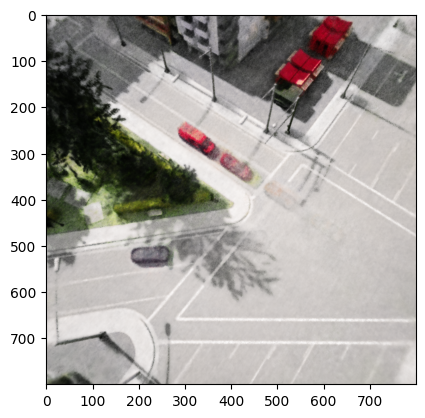

In [3]:
gui.render_bev()